In [11]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

Crimes happen at mealtime and other fun findings
================================================

Just kidding, the meal time thing is the only interesting fact I found
---------------------------------------------------------------------

In this assignment, we analyze criminal incident data from Seattle and San Francisco. The goal is to find and highlight patterns.

We will focus on offense type and time of occurrence (which month, what time).

In [19]:
library(ggplot2)
library(lubridate)
library(ggthemes)
seattle=read.csv("seattle_incidents_summer_2014.csv", header=T)
fmt="%m/%d/%Y %I:%M:%S %p"
sstart=strptime(as.character(seattle$Occurred.Date.or.Date.Range.Start),format=fmt)
seattle$city="Seattle"
sf=read.csv("sanfrancisco_incidents_summer_2014.csv", header=T)
sfstart=strptime(paste(sf$Date, sf$Time),format="%m/%d/%Y %H:%M")
sf$city="San Francisco"
mydata=data.frame(city=c(seattle$city,sf$city),datetime=c(sstart,sfstart),type=c(as.character(seattle$Offense.Type),as.character(sf$Category)))
types=as.character(mydata$type)

types_1=c("ASSLT.*","ASSAULT", # assault
    ".*BURGLARY.*",".*ROBBERY.*",".*THEFT.*",  # theft/robbery/burglary
    ".*NARC.*", # drugs/narcotics
    "FRAUD.*", # fraud
    "WARR.*", # warrants
    ".*WEAPON.*") # weapon
types_2=c(rep("assault",2),rep("theft/robbery/burglary",3),"drugs/narcotics","fraud","warrants","weapon")

for(i in seq_along(types_1)){
    types=gsub(types_1[i],types_2[i],types)
}

types=gsub(".*[A-Z].*","other",types)

mydata$type=as.factor(types)

## Polishing the datasets

Since we are using both the datasets for Seattle and San Francisco, we need to do a bit of data scrubbing. We will record, for each dataset:

* the date of the crime
* the type of crime
* the city

The type of crime will be one of the following categories: assault, drugs/narcotics, fraud, theft/robbery/burglary, warrants, weapon, other

## Crimes by hour of day

Let us first analyze the occurrencies of incidents with repect to the time, both in Seattle and San Francisco.

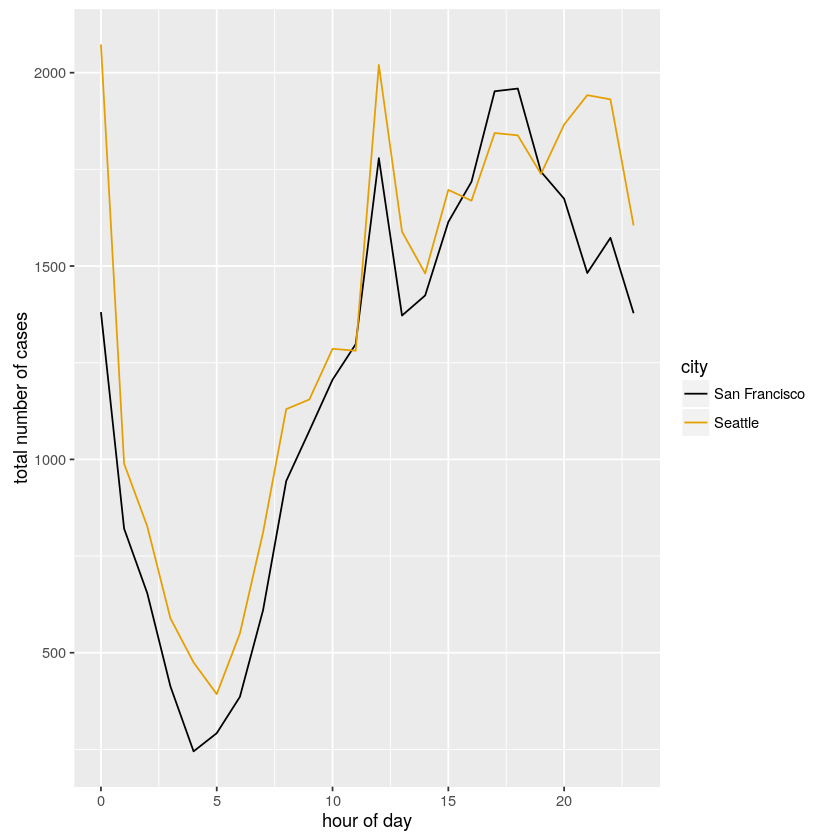

In [20]:
library(reshape2)
mydata$date=floor_date(mydata$datetime,unit="day")
mydata$hour = as.integer(format(mydata$datetime,format="%H"))
byhours=melt(with(mydata,table(hour,city,type)))
byhourstot=melt(with(mydata,table(hour,city)))

ggplot(data=byhourstot,aes(x=hour,y=value)) + geom_line(aes(color=city)) + ylab("total number of cases") + xlab("hour of day") + scale_color_colorblind()

We can observe the following:

* crime rates in both cities are similar
* crime is higher from noon to midnight than from midnight to noon
* 4-5am is the time period with less crime
* spikes happen at midnight, noon (lunch break), 6-7pm for San Francisco (dinner), 9-10pm for Seattle

Let's now have a look at the occurrencies by type of crime.

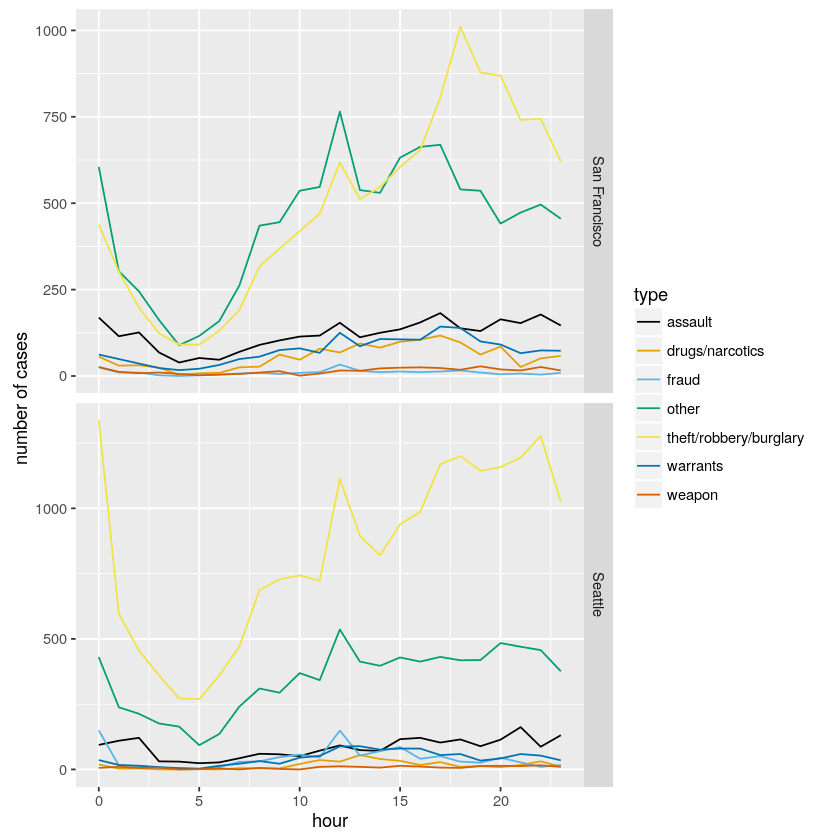

In [21]:
ggplot(data=byhours,aes(x=hour,y=value)) + geom_line(aes(color=type)) + facet_grid(city ~ ., scales = "free_y") + scale_color_colorblind() + ylab("number of cases")


We can see that all types of crime behave similarly.


## Crimes by date

Now, we will analyze the crimes with respect to the date, not taking account the time. Since there is noise from one day to another, we smooth our data.

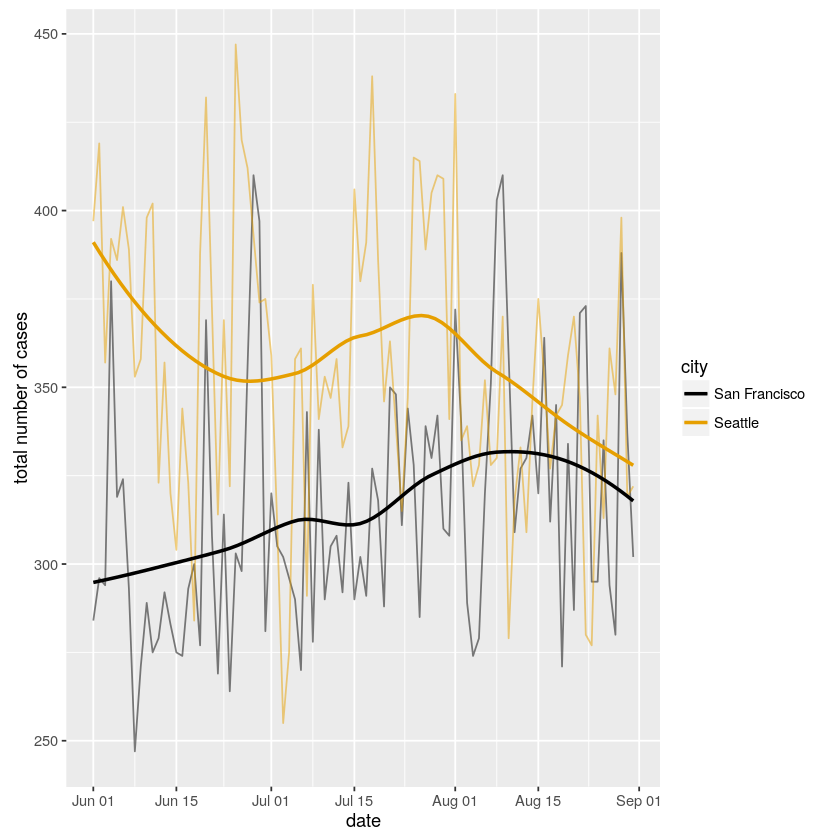

In [5]:
bydate=melt(with(mydata,table(date,city,type)))
bydatetot=melt(with(mydata,table(date,city)))
bydatetot$date=strptime(bydatetot$date, format="%Y-%m-%d")

ggplot(data=bydatetot,aes(x=date,y=value)) + geom_line(aes(color=city),alpha=0.5) + ylab("total number of cases") + stat_smooth(aes(color=city),level=0.9, method="loess",alpha=0) + scale_color_colorblind()


We can see that crime in the two cities evolves differently:

* in San Francisco, it goes up until mid-august and then decreases
* in Seattle, it goes down until beginning of July, then up until the end of the month, then down.


Now, let' s see the trends by type of crime


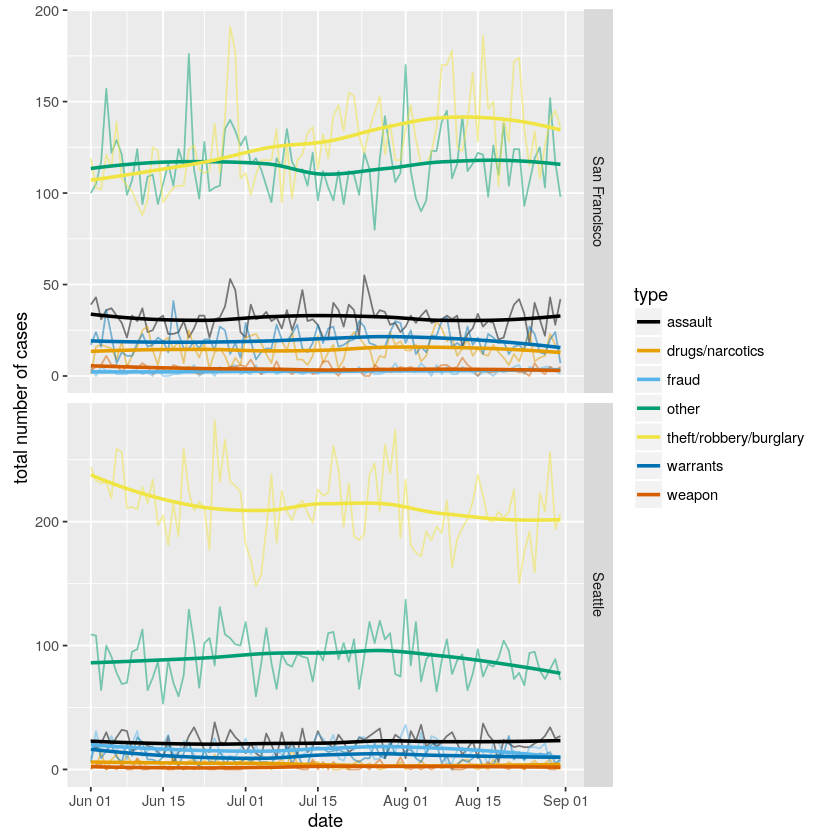

In [6]:
bydate$date=strptime(bydate$date, format="%Y-%m-%d")
ggplot(data=bydate,aes(x=date,y=value, group=type)) + geom_line(aes(color=type),alpha=0.5) + ylab("total number of cases") + stat_smooth(aes(color=type),alpha=0, method="loess") + facet_grid(city ~ ., scales="free_y")+ scale_color_colorblind()



Contrary to the time, we do not see the same trends in the single crime types.

## Relationship between time of crimes and date

In this section, we will see how the time of crime changes with the date.

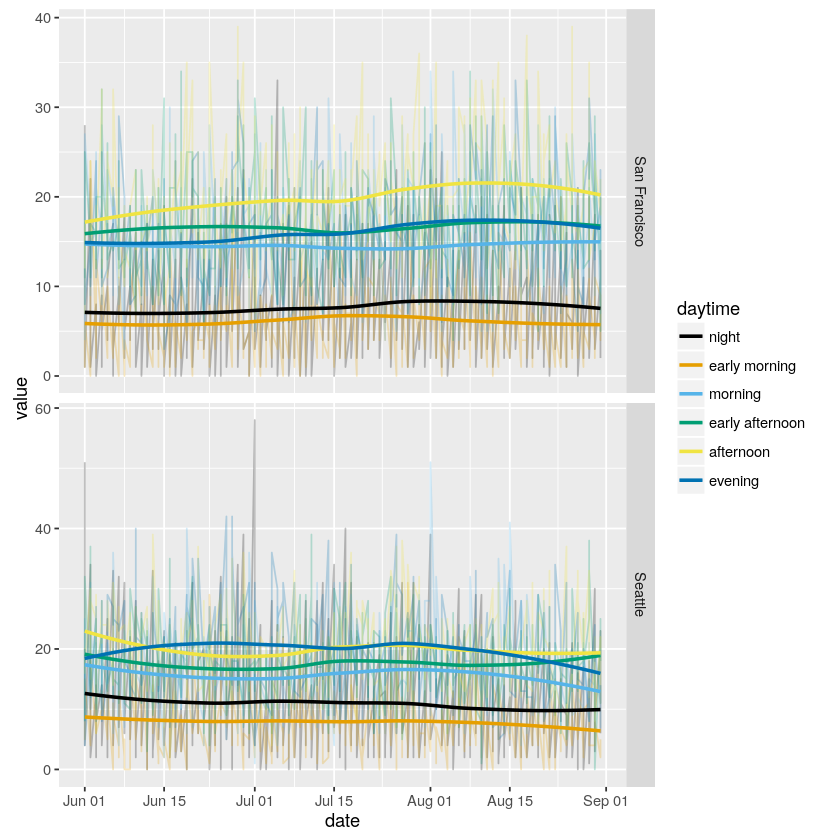

In [7]:
datevshour=melt(with(mydata,table(date,hour,city)))
datevshour$date=strptime(datevshour$date, format="%Y-%m-%d")
datevshour$daytime=cut(datevshour$hour,breaks=c(-1,4,8,12,16,20,24), labels=c("night","early morning", "morning","early afternoon", "afternoon", "evening"))
ggplot(data=datevshour,aes(x=date,y=value)) + geom_line(aes(color=daytime),alpha=0.25) + stat_smooth(aes(color=daytime),alpha=0, method="loess") + facet_grid(city ~ ., scales="free_y") + scale_color_colorblind()

and now, by crime type

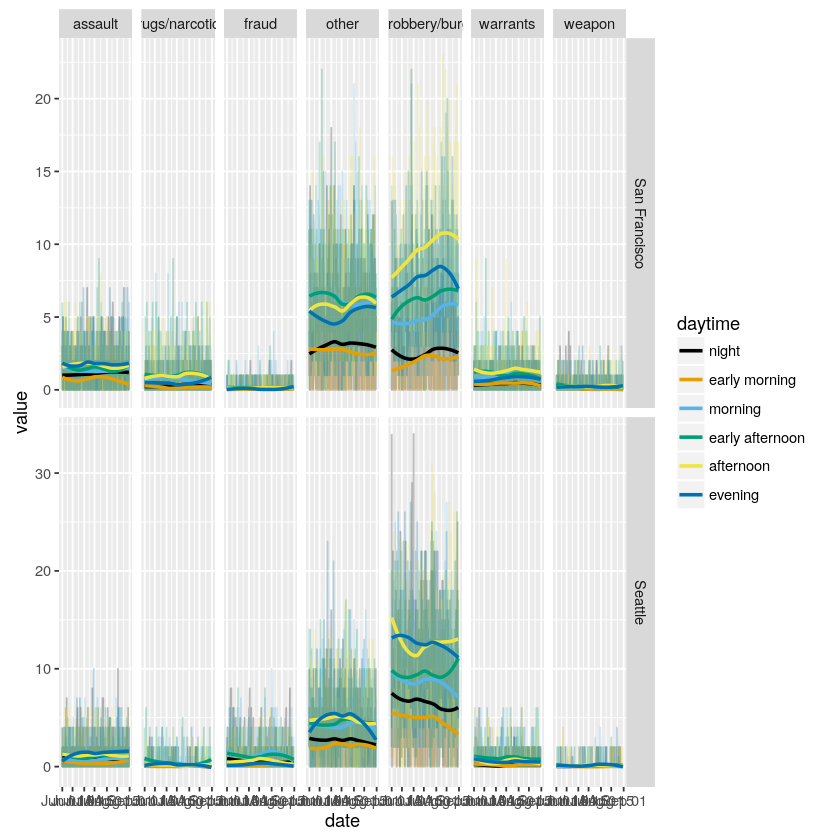

In [8]:
datevshour=melt(with(mydata,table(date,hour,city,type)))
datevshour$date=strptime(datevshour$date, format="%Y-%m-%d")
datevshour$daytime=cut(datevshour$hour,breaks=c(-1,4,8,12,16,20,24), labels=c("night","early morning", "morning","early afternoon", "afternoon", "evening"))
ggplot(data=datevshour,aes(x=date,y=value)) + geom_line(aes(color=daytime),alpha=0.25) + stat_smooth(aes(color=daytime),alpha=0, method="loess") + facet_grid(city ~ type, scales="free_y") + scale_color_colorblind()